# **Subset the LULCC data to shapefile**

By Bridget Bittmann

Date created: March 14, 2022

In [22]:
## IMPORT PACKAGES ##

import numpy as np #basic computation
!pip install geopandas
import geopandas as gpd #geopandas for .shp
import matplotlib.pyplot as plt #to create plots
import pandas as pd #to create dataframes and export .csv
!pip install rasterio
import rasterio as rso #import GeoTiff files
from rasterio.mask import mask #to crop data to a boundary
from rasterio.plot import show #to plot the image
from rasterio.crs import CRS
from shapely.ops import unary_union #creates boundary of shapefile
import json #imports metadata
!pip install rioxarray #to clip rasters to a .shp file
import rioxarray as rxr
from rasterio.warp import calculate_default_transform, reproject, Resampling
!pip install pylandstats
import pylandstats


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
## NAVIGATE TO YOUR DIRECTORY ##
%cd gdrive/MyDrive/spatial_colab/datasets/
%ls

/content/gdrive/MyDrive/spatial_colab/datasets
2005a.tif  2010.tif  2016.tif    2021.tif               irrig_lbrb/
2006.tif   2011.tif  2017.tif    Boise_CDL/             IrrMapper/
2007a.tif  2012.tif  2018.tif    CDL_reproject/         LBRB_shp/
2007b.tif  2013.tif  2019.tif    CDL_subsets/           masked/
2008.tif   2014.tif  2020.tif    diversion_timeseries/  subset_test_shp/
2009.tif   2015.tif  2021_clip/  irrigation_companies/


In [72]:
## CREATE A FUNCTION TO SUBSET GEOSPATIAL DATA ##
## ------------------------------------------- ##

shp_file = gpd.read_file('subset_test_shp/subset.shp') #open shapefile
div_name = list(shp_file['DIV_NAME_'])
data = rso.open('Boise_CDL/CDLs_boisearea/RasExt_CDL_2008_30m.tif') #open cdl image
shp = shp_file.to_crs(data.crs) #reproject the shp file to same projection
extent = shp['geometry'] #get the geometry from shapefile
boundary = gpd.GeoSeries(unary_union(extent)) #gets the boundary of the whole extent
# coords = [json.loads(extent.to_json())['features'][0]['geometry']] #gets coordinates for rasterio input
out_img = np.empty((4,1029,2184))
for i in range(len(shp)):
  extent = shp['geometry'][i]
  print(extent)
  coords = [json.loads(extent.to_json())['features'][0]['geometry']]
  out_img, out_transform = mask(dataset=data, shapes=coords, crop=True, nodata=0)
  out_meta = data.meta.copy()
  show(out_img)

out_img.shape

POLYGON ((-1641847.52714983 2481500.0457252273, -1641813.0135026327 2481478.352665821, -1641753.1283505436 2481538.196465026, -1641574.7577721337 2481496.3400380686, -1641373.247006132 2481533.035923893, -1641141.9094140127 2481594.6076361714, -1640943.6349562807 2481631.918196085, -1640726.618899417 2481646.514002732, -1640763.1310393482 2481464.9932060903, -1640603.9667790653 2481412.6735658497, -1640471.5435849759 2481403.0961270207, -1640365.7497188137 2481402.7649236885, -1640122.9412673952 2481419.0249106567, -1639952.8597131665 2481419.21829306, -1639835.3715951378 2481409.300118577, -1639552.2829797002 2481348.5294749057, -1639162.9738538063 2481255.818946604, -1638772.4763284274 2481167.86752215, -1638729.9803923815 2481361.252664538, -1638333.7155777279 2481272.657215327, -1638026.4810390607 2481203.5852762875, -1637941.5145925605 2481184.482396053, -1637700.1209348082 2481142.860204253, -1637551.9314394828 2481110.033766575, -1637446.578402941 2481090.2982316054, -1637374.59

AttributeError: ignored

In [6]:
from pylandstats import landscape
from pylandstats import SpatioTemporalAnalysis
import glob

In [7]:
ls = landscape.Landscape('masked/Extract_RasE1.tif', nodata=0)
prop = ls.compute_class_metrics_df(metrics=['proportion_of_landscape'])


In [14]:
dst_crs = {'EPSG':'8826'}

with rso.open('Boise_CDL/CDLs_boisearea/RasExt_CDL_2008_30m.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rso.open('Boise_CDL/CDLs_boisearea/RasExt_CDL_2008_30m.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rso.band(src, i),
                destination=rso.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

CRSError: ignored

In [8]:
## Import multiple rasters into PyLandStats ##
## ---------------------------------------- ##

years = np.arange(2008, 2022)
shp_file = gpd.read_file('subset_test_shp/subset.shp') #open shapefile
data = rso.open('Boise_CDL/CDLs_boisearea/RasExt_CDL_2010_30m.tif') #open cdl image
shp_file = shp_file.to_crs(data.crs) #reproject the shp file to same projection
shp_file.crs
files = glob.glob('Boise_CDL/CDLs_boisearea/*.tif') #name for all the csv files
sta = SpatioTemporalAnalysis(files, dates=years, mask=shp_file) #import all CDL rasters and mask

In [9]:
df = SpatioTemporalAnalysis.compute_class_metrics_df(sta, metrics=['proportion_of_landscape'])

In [10]:
display(df)

metric           proportion_of_landscape
class_val dates                         
1         2008                  2.530515
          2009                  2.735115
          2010                  2.833347
          2011                  3.691161
          2012                  3.686332
...                                  ...
250       2017                  0.000000
          2018                  0.000000
          2019                  0.000000
          2020                  0.000000
          2021                  0.000000

[1232 rows x 1 columns]

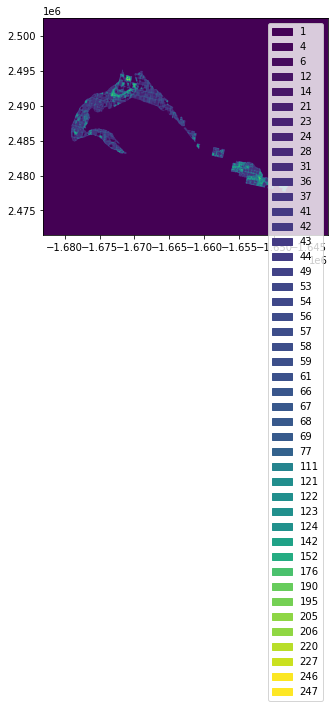

In [11]:
data = rso.open('masked/Extract_RasE1.tif')

landscape.Landscape.plot_landscape(ls, legend=True)

In [12]:
display(prop)
len(prop)

,proportion_of_landscape
class_val,
1,11.265984
4,0.020319
6,0.005418
12,0.330516
14,0.001355
21,0.100238
23,0.205895
24,10.541287
28,0.161194


45